<a href="https://colab.research.google.com/github/delhian/cv_course/blob/main/Home%20Tasks/CV_project1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [219]:
import os
from typing import Tuple
import numpy as np
from torch.utils.data import Dataset, Subset
import torch
from torchvision.datasets import ImageFolder, DatasetFolder
from torchvision import transforms
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import pandas as pd
import torch.nn as nn

from torchvision import models
from tqdm.notebook import tqdm

from sklearn.metrics import accuracy_score
from torch.optim.lr_scheduler import ExponentialLR
from PIL import Image

In [2]:
torch.cuda.is_available()

True

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
path = '/content/drive/MyDrive/CV_project1_data.zip'
!unzip -qqo {path} -d ./

In [189]:
LabelMapper = {'elon_musk': 0, 'mark_zuckerberg': 1, 'bill_gates':2, 'jeff_bezos':3, 'steve_jobs':4}
LabelUnMapper = {y: x for x, y in LabelMapper.items()}

In [233]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])


train_transforms = transforms.Compose([\
                                              transforms.RandomRotation(10,),
                                              transforms.Resize([70, 70]),
                                              transforms.ToTensor()
                                       ])
valid_transforms = transforms.Compose([
                                              transforms.Resize([70, 70]),
                                              transforms.ToTensor()
                                     ])

In [192]:
class CustomDataset(Dataset):
    def __init__(self, path, transform, normalize = None):
        files = []
        for (dirpath, _, filenames) in os.walk(path):
          for filename in filenames:
            if filename.endswith('.jpg'):
              files.append([dirpath+'/'+filename, filename, dirpath.split('/')[-1]])
        files = pd.DataFrame(files, columns = ['dirpath', 'filenames' ,'labels'])
        files['labels'] = files['labels'].map(LabelMapper)
        self.dirpath = files['dirpath'].to_dict()
        self.filenames = files['filenames'].to_dict()
        self.labels = files['labels'].to_dict()
        self.transform = transform
        self.normalize = normalize

    def __len__(self):
        return len(self.filenames)

    def pil_loader(self, path):
        with open(path, 'rb') as f:
            img = Image.open(f)
            return img.convert('RGB')

    def __getitem__(self, idx):
        path = self.dirpath[idx]
        label = self.labels[idx]
        label = torch.LongTensor([label]).squeeze() 
        file_name = self.filenames[idx]
        image = self.pil_loader(path)
        image = self.transform(image)
        if self.normalize:
            image = self.normalize(image)
        return image, file_name, label

In [193]:
train_path = '/content/data/train/'
valid_path = '/content/data/valid/'

batch_size = 16

train_dataset = CustomDataset(path = train_path, transform = train_transforms)
valid_dataset = CustomDataset(path = valid_path, transform = valid_transforms)

train_dataloader = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=os.cpu_count())
valid_dataloader = DataLoader(valid_dataset, batch_size, num_workers=os.cpu_count())

train_dataloader:


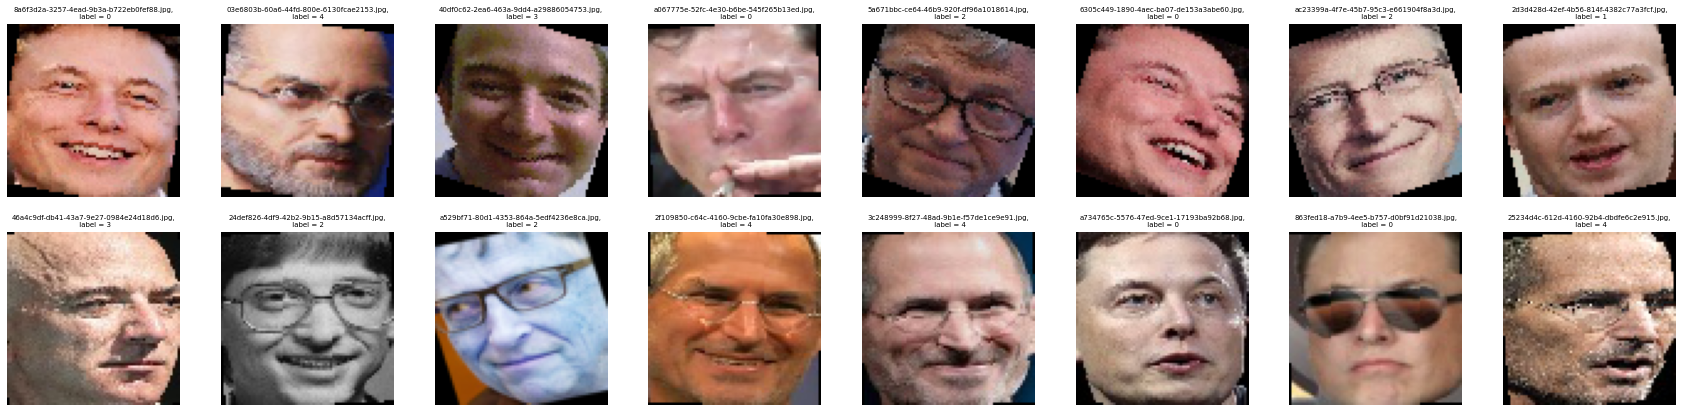

val_dataloader:


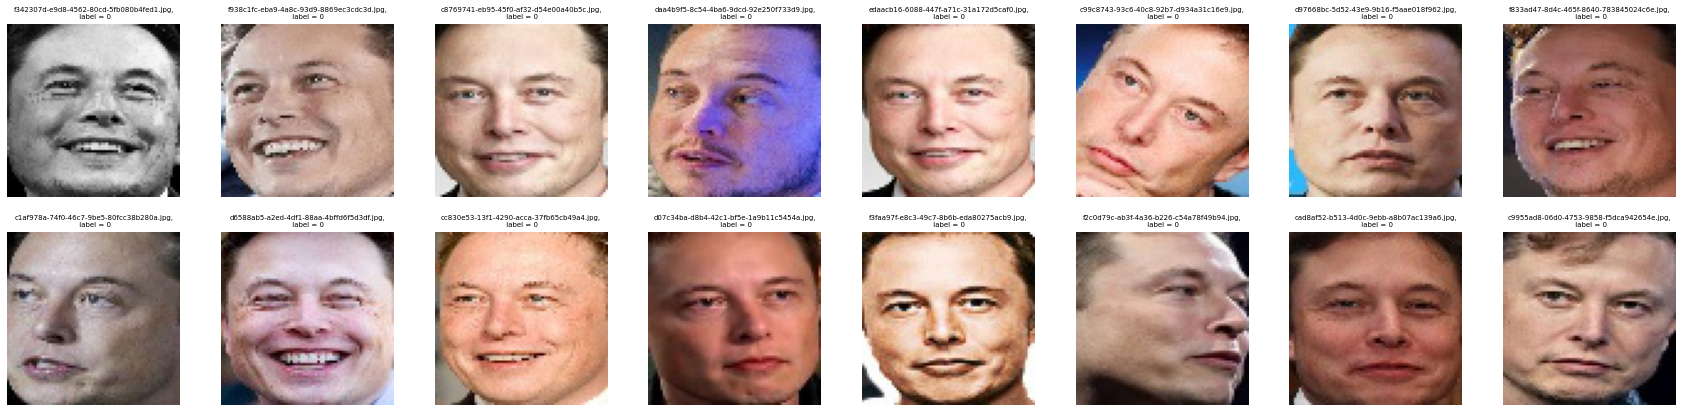

In [194]:
def plot_examples(image, file_name, label):
  figure = plt.figure(figsize=(30, 7))
  cols, rows = 8,2
  for i in range(0, cols * rows):
    figure.add_subplot(rows, cols, i+1)
    plt.title(f'{file_name[i]},\n label = {label[i].item()}', fontsize = 7)
    plt.axis("off")
    plt.imshow(image[i].numpy().transpose([1,2,0]))
  plt.show()

print('train_dataloader:')
image, file_name, label = next(iter(train_dataloader))
plot_examples(image, file_name, label)
print('val_dataloader:')
image, file_name, label = next(iter(valid_dataloader))
plot_examples(image, file_name, label)

In [260]:
batch_size = 256
train_dataset = CustomDataset(path = train_path, transform = train_transforms)
valid_dataloader = CustomDataset(path = valid_path, transform = valid_transforms)

train_dataloader = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=os.cpu_count())
valid_dataloader = DataLoader(valid_dataset, batch_size, num_workers=os.cpu_count())

In [261]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [262]:
checkpoint_path = '/content/drive/MyDrive/CV_project1_checkpoint.pth'

def save_checkpoint(model, optimizer, checkpoint_path, epoch, loss_train, accuracy_train, loss_valid, accuracy_valid):
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'epoch': epoch,
        'loss_train': loss_train,
        'accuracy_train': accuracy_train,
        'loss_valid': loss_valid,
        'accuracy_valid': accuracy_valid,
    }, checkpoint_path)

def load_checkpoint(model, checkpoint_path, optimizer):
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    loss_train = checkpoint['loss_train']
    accuracy_train = checkpoint['accuracy_train']
    loss_valid = checkpoint['loss_valid']
    accuracy_valid = checkpoint['accuracy_valid']
    return model, optimizer, epoch, loss_train, accuracy_train, loss_valid, accuracy_valid

In [267]:
def train_model(net,
                optimizer,
                criterion,
                train_dataloader,
                val_dataloader,
                num_epochs):

    if os.path.isfile(checkpoint_path):
      net, optimizer, start_epoch, loss_train, accuracy_train, loss_valid, accuracy_valid = load_checkpoint(net, checkpoint_path, optimizer)
    else:
      loss_train, accuracy_train, loss_valid, accuracy_valid = [], [], [], []
      start_epoch = 0

    scheduler = ExponentialLR(optimizer, gamma=0.95)

    for epoch in range(start_epoch + 1, num_epochs + 1):
        print(f'epoch: {epoch} of {num_epochs}')
        print(f'current Learning Rate: {scheduler.get_last_lr()[0]}')
        torch.set_grad_enabled(True)
        net.train()
        losses, acc = [], []

        print('TRAIN:', end =' ')
        for i, (image, _, label) in enumerate(tqdm(train_dataloader)):
            image = image.to(device)
            label = label.to(device)
            output = net(image)
            loss = criterion(output, label)
            try:
              losses.append(loss.item())
            except:
              return losses, loss

            acc.append(accuracy_score(label.cpu().numpy(), output.argmax(1).cpu().numpy()))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        mean_losses, mean_acc = np.mean(losses),  np.mean(acc)
        print(f'mean_losses: {mean_losses}, mean_acc: {mean_acc}')
        loss_train.append(mean_losses)
        accuracy_train.append(mean_acc)
        torch.set_grad_enabled(False)
        net.eval()
        losses, acc = [], []
        print('VALIDATION:', end =' ')
        for i, (image, _, label) in enumerate(tqdm(val_dataloader)):
            # print(i, end =', ')
            image = image.to(device)
            label = label.to(device)
            output = net(image)
            loss = criterion(output, label)
            losses.append(loss.item())
            acc.append(accuracy_score(label.cpu().numpy(), output.argmax(1).cpu().numpy()))
        mean_losses, mean_acc = np.mean(losses),  np.mean(acc)
        print(f'mean_losses: {mean_losses}, mean_acc: {mean_acc}')

        loss_valid.append(mean_losses)
        accuracy_valid.append(mean_acc)
        scheduler.step()
        save_checkpoint(net, optimizer, checkpoint_path, epoch, loss_train, accuracy_train, loss_valid, accuracy_valid)
    return loss_train, accuracy_train, loss_valid, accuracy_valid


def f_print_results(loss_train, loss_valid, accuracy_train, accuracy_valid): 
  plt.figure(figsize=(18, 6))
  plt.subplot(121)
  plt.plot(range(1, len(loss_train) + 1), loss_train, color="b")
  plt.plot(range(1, len(loss_train) + 1), loss_valid, color="r" , )
  plt.xlabel("epochs")
  plt.legend(['train', 'valid'])
  plt.title("loss")
  plt.subplot(122)
  plt.plot(range(1, len(loss_train) + 1), accuracy_train, color="b")
  plt.plot(range(1, len(loss_train) + 1), accuracy_valid, color="r")
  plt.xlabel("epochs")
  plt.title("mean_acc")
  plt.legend(['train', 'valid'])
  plt.show()

In [269]:
net = models.densenet161(pretrained=True)
net.classifier =  torch.nn.Linear(in_features=2208, out_features=5, bias=True)

requires_grads = [x > 10 for x in range(len(net.features))]
print(f'requires_grads: {requires_grads}')

for ind, flag in enumerate(requires_grads):
  for param in net.features[ind].parameters():
    param.requires_grad = flag

net = net.to(device)

requires_grads: [False, False, False, False, False, False, False, False, False, False, False, True]


epoch: 1 of 20
current Learning Rate: 0.01
TRAIN: 

  0%|          | 0/12 [00:00<?, ?it/s]

mean_losses: 2.0075357059637704, mean_acc: 0.4447039175724638
VALIDATION: 

  0%|          | 0/4 [00:00<?, ?it/s]

mean_losses: 1.103721484541893, mean_acc: 0.609562285958904
epoch: 2 of 20
current Learning Rate: 0.0095
TRAIN: 

  0%|          | 0/12 [00:00<?, ?it/s]

mean_losses: 0.7085313151280085, mean_acc: 0.7482308650362319
VALIDATION: 

  0%|          | 0/4 [00:00<?, ?it/s]

mean_losses: 0.6285462081432343, mean_acc: 0.7647019477739726
epoch: 3 of 20
current Learning Rate: 0.009025
TRAIN: 

  0%|          | 0/12 [00:00<?, ?it/s]

mean_losses: 0.5547506163517634, mean_acc: 0.8059895833333334
VALIDATION: 

  0%|          | 0/4 [00:00<?, ?it/s]

mean_losses: 0.5759572088718414, mean_acc: 0.812847816780822
epoch: 4 of 20
current Learning Rate: 0.00857375
TRAIN: 

  0%|          | 0/12 [00:00<?, ?it/s]

mean_losses: 0.4433195839325587, mean_acc: 0.8449671648550724
VALIDATION: 

  0%|          | 0/4 [00:00<?, ?it/s]

mean_losses: 0.37664229422807693, mean_acc: 0.8727391909246576
epoch: 5 of 20
current Learning Rate: 0.0081450625
TRAIN: 

  0%|          | 0/12 [00:00<?, ?it/s]

mean_losses: 0.3914140934745471, mean_acc: 0.873046875
VALIDATION: 

  0%|          | 0/4 [00:00<?, ?it/s]

mean_losses: 0.36829419434070587, mean_acc: 0.8776353809931507
epoch: 6 of 20
current Learning Rate: 0.007737809374999999
TRAIN: 

  0%|          | 0/12 [00:00<?, ?it/s]

mean_losses: 0.36012525856494904, mean_acc: 0.8844259510869565
VALIDATION: 

  0%|          | 0/4 [00:00<?, ?it/s]

mean_losses: 0.35538268089294434, mean_acc: 0.875187285958904
epoch: 7 of 20
current Learning Rate: 0.007350918906249998
TRAIN: 

  0%|          | 0/12 [00:00<?, ?it/s]

mean_losses: 0.3566421990593274, mean_acc: 0.8862658514492754
VALIDATION: 

  0%|          | 0/4 [00:00<?, ?it/s]

mean_losses: 0.43932627886533737, mean_acc: 0.8639233732876712
epoch: 8 of 20
current Learning Rate: 0.006983372960937498
TRAIN: 

  0%|          | 0/12 [00:00<?, ?it/s]

mean_losses: 0.3342682222525279, mean_acc: 0.8887284873188405
VALIDATION: 

  0%|          | 0/4 [00:00<?, ?it/s]

mean_losses: 0.3044523261487484, mean_acc: 0.896658283390411
epoch: 9 of 20
current Learning Rate: 0.006634204312890623
TRAIN: 

  0%|          | 0/12 [00:00<?, ?it/s]

mean_losses: 0.29867445429166156, mean_acc: 0.9002490942028986
VALIDATION: 

  0%|          | 0/4 [00:00<?, ?it/s]

mean_losses: 0.35683006793260574, mean_acc: 0.8854478809931507
epoch: 10 of 20
current Learning Rate: 0.006302494097246091
TRAIN: 

  0%|          | 0/12 [00:00<?, ?it/s]

mean_losses: 0.2787811818222205, mean_acc: 0.9037732110507246
VALIDATION: 

  0%|          | 0/4 [00:00<?, ?it/s]

mean_losses: 0.32376008853316307, mean_acc: 0.8927921660958904
epoch: 11 of 20
current Learning Rate: 0.005987369392383786
TRAIN: 

  0%|          | 0/12 [00:00<?, ?it/s]

mean_losses: 0.2767129528025786, mean_acc: 0.9033627717391304
VALIDATION: 

  0%|          | 0/4 [00:00<?, ?it/s]

mean_losses: 0.3104270212352276, mean_acc: 0.9010862585616438
epoch: 12 of 20
current Learning Rate: 0.005688000922764597
TRAIN: 

  0%|          | 0/12 [00:00<?, ?it/s]

mean_losses: 0.25686705112457275, mean_acc: 0.9199501811594203
VALIDATION: 

  0%|          | 0/4 [00:00<?, ?it/s]

mean_losses: 0.28985393792390823, mean_acc: 0.9118284460616438
epoch: 13 of 20
current Learning Rate: 0.005403600876626367
TRAIN: 

  0%|          | 0/12 [00:00<?, ?it/s]

mean_losses: 0.25560687358180684, mean_acc: 0.9143880208333334
VALIDATION: 

  0%|          | 0/4 [00:00<?, ?it/s]

mean_losses: 0.3368155360221863, mean_acc: 0.8888725385273972
epoch: 14 of 20
current Learning Rate: 0.005133420832795048
TRAIN: 

  0%|          | 0/12 [00:00<?, ?it/s]

mean_losses: 0.24154768014947572, mean_acc: 0.9267861186594203
VALIDATION: 

  0%|          | 0/4 [00:00<?, ?it/s]

mean_losses: 0.3188939653337002, mean_acc: 0.895681720890411
epoch: 15 of 20
current Learning Rate: 0.0048767497911552955
TRAIN: 

  0%|          | 0/12 [00:00<?, ?it/s]

mean_losses: 0.22373316685358682, mean_acc: 0.9240687273550724
VALIDATION: 

  0%|          | 0/4 [00:00<?, ?it/s]

mean_losses: 0.30094135738909245, mean_acc: 0.9183968321917808
epoch: 16 of 20
current Learning Rate: 0.00463291230159753
TRAIN: 

  0%|          | 0/12 [00:00<?, ?it/s]

mean_losses: 0.21048764511942863, mean_acc: 0.926474750905797
VALIDATION: 

  0%|          | 0/4 [00:00<?, ?it/s]

mean_losses: 0.31803372874855995, mean_acc: 0.8981298159246576
epoch: 17 of 20
current Learning Rate: 0.0044012666865176535
TRAIN: 

  0%|          | 0/12 [00:00<?, ?it/s]

mean_losses: 0.20507127667466798, mean_acc: 0.9299847146739131
VALIDATION: 

  0%|          | 0/4 [00:00<?, ?it/s]

mean_losses: 0.2770806737244129, mean_acc: 0.9130458047945206
epoch: 18 of 20
current Learning Rate: 0.004181203352191771
TRAIN: 

  0%|          | 0/12 [00:00<?, ?it/s]

mean_losses: 0.19470245391130447, mean_acc: 0.9351222826086957
VALIDATION: 

  0%|          | 0/4 [00:00<?, ?it/s]

mean_losses: 0.29507366567850113, mean_acc: 0.908644584760274
epoch: 19 of 20
current Learning Rate: 0.003972143184582182
TRAIN: 

  0%|          | 0/12 [00:00<?, ?it/s]

mean_losses: 0.19426017254590988, mean_acc: 0.9394814311594203
VALIDATION: 

  0%|          | 0/4 [00:00<?, ?it/s]

mean_losses: 0.2699089255183935, mean_acc: 0.917433647260274
epoch: 20 of 20
current Learning Rate: 0.0037735360253530726
TRAIN: 

  0%|          | 0/12 [00:00<?, ?it/s]

mean_losses: 0.1877331348756949, mean_acc: 0.9438405797101449
VALIDATION: 

  0%|          | 0/4 [00:00<?, ?it/s]

mean_losses: 0.2755737826228142, mean_acc: 0.9157213184931507


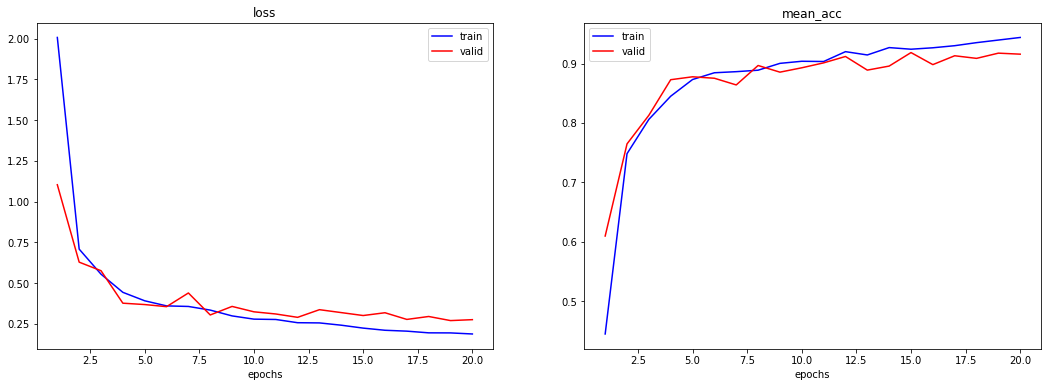

In [270]:
optimizer = torch.optim.Adam(net.parameters(), lr=1e-2)
criterion = nn.CrossEntropyLoss()

loss_train, accuracy_train, loss_valid, accuracy_valid = train_model(net = net,
                                                         optimizer = optimizer,
                                                         criterion = criterion,
                                                         train_dataloader = train_dataloader,
                                                         val_dataloader = valid_dataloader,
                                                         num_epochs = 20)

f_print_results(loss_train, loss_valid, accuracy_train, accuracy_valid)

In [271]:
requires_grads = [x > 8 for x in range(len(net.features))]
print(f'requires_grads: {requires_grads}')

for ind, flag in enumerate(requires_grads):
  for param in net.features[ind].parameters():
    param.requires_grad = flag

# optimizer = torch.optim.Adam(net.parameters(), lr=1e-2)
# criterion = nn.CrossEntropyLoss()

loss_train, accuracy_train, loss_valid, accuracy_valid = train_model(net = net,
                                                         optimizer = optimizer,
                                                         criterion = criterion,
                                                         train_dataloader = train_dataloader,
                                                         val_dataloader = valid_dataloader,
                                                         num_epochs = 40)

requires_grads: [False, False, False, False, False, False, False, False, False, True, True, True]
epoch: 21 of 40
current Learning Rate: 0.0035848592240854188
TRAIN: 

  0%|          | 0/12 [00:00<?, ?it/s]

mean_losses: 0.8744996301829815, mean_acc: 0.8144248188405797
VALIDATION: 

  0%|          | 0/4 [00:00<?, ?it/s]

mean_losses: 81.33079528808594, mean_acc: 0.5638778895547945
epoch: 22 of 40
current Learning Rate: 0.0034056162628811476
TRAIN: 

  0%|          | 0/12 [00:00<?, ?it/s]

mean_losses: 0.31257584939400357, mean_acc: 0.9533514492753623
VALIDATION: 

  0%|          | 0/4 [00:00<?, ?it/s]

mean_losses: 2.5048021227121353, mean_acc: 0.8905447345890412
epoch: 23 of 40
current Learning Rate: 0.0032353354497370902
TRAIN: 

  0%|          | 0/12 [00:00<?, ?it/s]

mean_losses: 0.19332434019694725, mean_acc: 0.9693444293478262
VALIDATION: 

  0%|          | 0/4 [00:00<?, ?it/s]

mean_losses: 0.4069782178848982, mean_acc: 0.9572720462328768
epoch: 24 of 40
current Learning Rate: 0.0030735686772502355
TRAIN: 

  0%|          | 0/12 [00:00<?, ?it/s]

mean_losses: 0.08548966236412525, mean_acc: 0.9832710597826088
VALIDATION: 

  0%|          | 0/4 [00:00<?, ?it/s]

mean_losses: 0.2310762871056795, mean_acc: 0.9582218535958904
epoch: 25 of 40
current Learning Rate: 0.0029198902433877237
TRAIN: 

  0%|          | 0/12 [00:00<?, ?it/s]

mean_losses: 0.06750353953490655, mean_acc: 0.9871773097826088
VALIDATION: 

  0%|          | 0/4 [00:00<?, ?it/s]

mean_losses: 0.08228799072094262, mean_acc: 0.9748501712328768
epoch: 26 of 40
current Learning Rate: 0.0027738957312183374
TRAIN: 

  0%|          | 0/12 [00:00<?, ?it/s]

mean_losses: 0.0956111370275418, mean_acc: 0.9890738224637681
VALIDATION: 

  0%|          | 0/4 [00:00<?, ?it/s]

mean_losses: 0.3322831988334656, mean_acc: 0.964576198630137
epoch: 27 of 40
current Learning Rate: 0.0026352009446574203
TRAIN: 

  0%|          | 0/12 [00:00<?, ?it/s]

mean_losses: 0.05632754624821246, mean_acc: 0.9922016530797101
VALIDATION: 

  0%|          | 0/4 [00:00<?, ?it/s]

mean_losses: 0.2769866846501827, mean_acc: 0.9560413099315068
epoch: 28 of 40
current Learning Rate: 0.002503440897424549
TRAIN: 

  0%|          | 0/12 [00:00<?, ?it/s]

mean_losses: 0.05638488727466514, mean_acc: 0.9915364583333334
VALIDATION: 

  0%|          | 0/4 [00:00<?, ?it/s]

mean_losses: 0.12221124954521656, mean_acc: 0.9721612799657534
epoch: 29 of 40
current Learning Rate: 0.0023782688525533216
TRAIN: 

  0%|          | 0/12 [00:00<?, ?it/s]

mean_losses: 0.0326288768555969, mean_acc: 0.995315330615942
VALIDATION: 

  0%|          | 0/4 [00:00<?, ?it/s]

mean_losses: 0.30327001959085464, mean_acc: 0.9579944349315068
epoch: 30 of 40
current Learning Rate: 0.0022593554099256553
TRAIN: 

  0%|          | 0/12 [00:00<?, ?it/s]

mean_losses: 0.052697874372825027, mean_acc: 0.9935603487318841
VALIDATION: 

  0%|          | 0/4 [00:00<?, ?it/s]

mean_losses: 0.2960871607065201, mean_acc: 0.9680008561643836
epoch: 31 of 40
current Learning Rate: 0.0021463876394293723
TRAIN: 

  0%|          | 0/12 [00:00<?, ?it/s]

mean_losses: 0.047679905546829104, mean_acc: 0.9942113903985508
VALIDATION: 

  0%|          | 0/4 [00:00<?, ?it/s]

mean_losses: 0.3182090260088444, mean_acc: 0.9636130136986302
epoch: 32 of 40
current Learning Rate: 0.0020390682574579037
TRAIN: 

  0%|          | 0/12 [00:00<?, ?it/s]

mean_losses: 0.054634625324979424, mean_acc: 0.994140625
VALIDATION: 

  0%|          | 0/4 [00:00<?, ?it/s]

mean_losses: 0.1707359403371811, mean_acc: 0.9684958261986302
epoch: 33 of 40
current Learning Rate: 0.0019371148445850085
TRAIN: 

  0%|          | 0/12 [00:00<?, ?it/s]

mean_losses: 0.028690610197372735, mean_acc: 0.9953860960144928
VALIDATION: 

  0%|          | 0/4 [00:00<?, ?it/s]

mean_losses: 0.5121183367446065, mean_acc: 0.9411119434931507
epoch: 34 of 40
current Learning Rate: 0.0018402591023557579
TRAIN: 

  0%|          | 0/12 [00:00<?, ?it/s]

mean_losses: 0.02791163936490193, mean_acc: 0.9966174139492754
VALIDATION: 

  0%|          | 0/4 [00:00<?, ?it/s]

mean_losses: 0.2187339608790353, mean_acc: 0.9794921875
epoch: 35 of 40
current Learning Rate: 0.0017482461472379698
TRAIN: 

  0%|          | 0/12 [00:00<?, ?it/s]

mean_losses: 0.03642564276621366, mean_acc: 0.9956408514492754
VALIDATION: 

  0%|          | 0/4 [00:00<?, ?it/s]

mean_losses: 0.13920060789678246, mean_acc: 0.9833850599315068
epoch: 36 of 40
current Learning Rate: 0.0016608338398760713
TRAIN: 

  0%|          | 0/12 [00:00<?, ?it/s]

mean_losses: 0.014636285874682168, mean_acc: 0.998046875
VALIDATION: 

  0%|          | 0/4 [00:00<?, ?it/s]

mean_losses: 0.06184136378578842, mean_acc: 0.9873046875
epoch: 37 of 40
current Learning Rate: 0.0015777921478822676
TRAIN: 

  0%|          | 0/12 [00:00<?, ?it/s]

mean_losses: 0.025375810141364735, mean_acc: 0.9956408514492754
VALIDATION: 

  0%|          | 0/4 [00:00<?, ?it/s]

mean_losses: 0.06346356982248835, mean_acc: 0.986328125
epoch: 38 of 40
current Learning Rate: 0.001498902540488154
TRAIN: 

  0%|          | 0/12 [00:00<?, ?it/s]

mean_losses: 0.030605045195746545, mean_acc: 0.9955134737318841
VALIDATION: 

  0%|          | 0/4 [00:00<?, ?it/s]

mean_losses: 0.1884318231168436, mean_acc: 0.9775390625
epoch: 39 of 40
current Learning Rate: 0.0014239574134637463
TRAIN: 

  0%|          | 0/12 [00:00<?, ?it/s]

mean_losses: 0.015223770732215295, mean_acc: 0.9973958333333334
VALIDATION: 

  0%|          | 0/4 [00:00<?, ?it/s]

mean_losses: 0.11232793983072042, mean_acc: 0.9787430436643836
epoch: 40 of 40
current Learning Rate: 0.0013527595427905588
TRAIN: 

  0%|          | 0/12 [00:00<?, ?it/s]

mean_losses: 0.014393490894387165, mean_acc: 0.9956408514492754
VALIDATION: 

  0%|          | 0/4 [00:00<?, ?it/s]

mean_losses: 0.1403056326089427, mean_acc: 0.9826492936643836


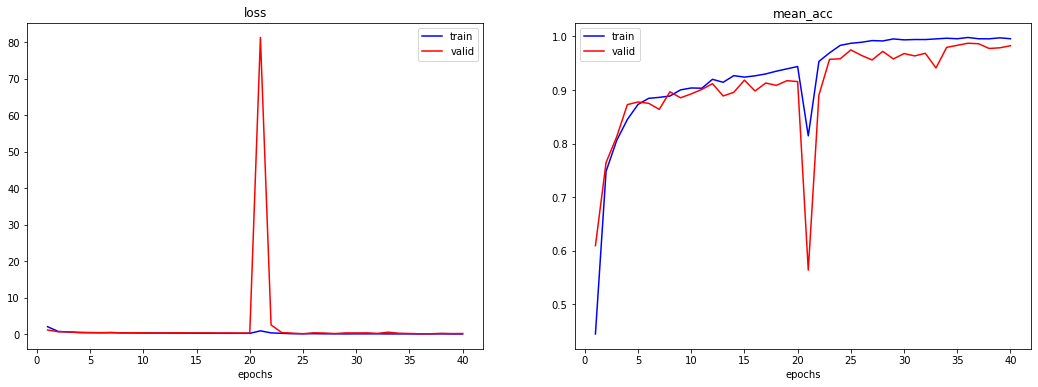

In [272]:
f_print_results(loss_train, loss_valid, accuracy_train, accuracy_valid)

requires_grads: [False, False, False, False, False, False, False, True, True, True, True, True]
epoch: 41 of 60
current Learning Rate: 0.0012851215656510308
TRAIN: 

  0%|          | 0/12 [00:00<?, ?it/s]

mean_losses: 0.2010817298820863, mean_acc: 0.9573709239130435
VALIDATION: 

  0%|          | 0/4 [00:00<?, ?it/s]

mean_losses: 226.86155319213867, mean_acc: 0.2104291523972603
epoch: 42 of 60
current Learning Rate: 0.0012208654873684791
TRAIN: 

  0%|          | 0/12 [00:00<?, ?it/s]

mean_losses: 0.057719506323337555, mean_acc: 0.9823652626811595
VALIDATION: 

  0%|          | 0/4 [00:00<?, ?it/s]

mean_losses: 4.8876565136015415, mean_acc: 0.7975706335616438
epoch: 43 of 60
current Learning Rate: 0.0011598222130000551
TRAIN: 

  0%|          | 0/12 [00:00<?, ?it/s]

mean_losses: 0.03518605573723713, mean_acc: 0.9890738224637681
VALIDATION: 

  0%|          | 0/4 [00:00<?, ?it/s]

mean_losses: 0.0679110640194267, mean_acc: 0.9873046875
epoch: 44 of 60
current Learning Rate: 0.0011018311023500522
TRAIN: 

  0%|          | 0/12 [00:00<?, ?it/s]

mean_losses: 0.013005193672142923, mean_acc: 0.9966174139492754
VALIDATION: 

  0%|          | 0/4 [00:00<?, ?it/s]

mean_losses: 0.040789111400954425, mean_acc: 0.9880270761986302
epoch: 45 of 60
current Learning Rate: 0.0010467395472325495
TRAIN: 

  0%|          | 0/12 [00:00<?, ?it/s]

mean_losses: 0.009218424054173132, mean_acc: 0.997268455615942
VALIDATION: 

  0%|          | 0/4 [00:00<?, ?it/s]

mean_losses: 0.033430847979616374, mean_acc: 0.9931640625
epoch: 46 of 60
current Learning Rate: 0.000994402569870922
TRAIN: 

  0%|          | 0/12 [00:00<?, ?it/s]

mean_losses: 0.007516930917821203, mean_acc: 0.9983723958333334
VALIDATION: 

  0%|          | 0/4 [00:00<?, ?it/s]

mean_losses: 0.02268535504117608, mean_acc: 0.9924282962328768
epoch: 47 of 60
current Learning Rate: 0.0009446824413773759
TRAIN: 

  0%|          | 0/12 [00:00<?, ?it/s]

mean_losses: 0.004929689166601747, mean_acc: 0.9985705389492754
VALIDATION: 

  0%|          | 0/4 [00:00<?, ?it/s]

mean_losses: 0.020800986618269235, mean_acc: 0.994140625
epoch: 48 of 60
current Learning Rate: 0.0008974483193085071
TRAIN: 

  0%|          | 0/12 [00:00<?, ?it/s]

mean_losses: 0.001934702944708988, mean_acc: 1.0
VALIDATION: 

  0%|          | 0/4 [00:00<?, ?it/s]

mean_losses: 0.024302217992953956, mean_acc: 0.9931640625
epoch: 49 of 60
current Learning Rate: 0.0008525759033430817
TRAIN: 

  0%|          | 0/12 [00:00<?, ?it/s]

mean_losses: 0.002219905346767822, mean_acc: 0.9996744791666666
VALIDATION: 

  0%|          | 0/4 [00:00<?, ?it/s]

mean_losses: 0.02379438330535777, mean_acc: 0.9951171875
epoch: 50 of 60
current Learning Rate: 0.0008099471081759276
TRAIN: 

  0%|          | 0/12 [00:00<?, ?it/s]

mean_losses: 0.002508855177438818, mean_acc: 0.9996744791666666
VALIDATION: 

  0%|          | 0/4 [00:00<?, ?it/s]

mean_losses: 0.022030151187209412, mean_acc: 0.9951171875
epoch: 51 of 60
current Learning Rate: 0.0007694497527671312
TRAIN: 

  0%|          | 0/12 [00:00<?, ?it/s]

mean_losses: 0.0010590741973525535, mean_acc: 0.9996744791666666
VALIDATION: 

  0%|          | 0/4 [00:00<?, ?it/s]

mean_losses: 0.02234712356585078, mean_acc: 0.9951171875
epoch: 52 of 60
current Learning Rate: 0.0007309772651287747
TRAIN: 

  0%|          | 0/12 [00:00<?, ?it/s]

mean_losses: 0.000790987663397876, mean_acc: 0.9996744791666666
VALIDATION: 

  0%|          | 0/4 [00:00<?, ?it/s]

mean_losses: 0.022766596797737293, mean_acc: 0.9951171875
epoch: 53 of 60
current Learning Rate: 0.0006944284018723359
TRAIN: 

  0%|          | 0/12 [00:00<?, ?it/s]

mean_losses: 0.0009300067031290382, mean_acc: 0.9996744791666666
VALIDATION: 

  0%|          | 0/4 [00:00<?, ?it/s]

mean_losses: 0.022037006143364124, mean_acc: 0.9951171875
epoch: 54 of 60
current Learning Rate: 0.0006597069817787191
TRAIN: 

  0%|          | 0/12 [00:00<?, ?it/s]

mean_losses: 0.0010976081096790342, mean_acc: 0.9996744791666666
VALIDATION: 

  0%|          | 0/4 [00:00<?, ?it/s]

mean_losses: 0.022205338653293438, mean_acc: 0.9951171875
epoch: 55 of 60
current Learning Rate: 0.0006267216326897832
TRAIN: 

  0%|          | 0/12 [00:00<?, ?it/s]

mean_losses: 0.0005191846976231318, mean_acc: 1.0
VALIDATION: 

  0%|          | 0/4 [00:00<?, ?it/s]

mean_losses: 0.02238577500975225, mean_acc: 0.9951171875
epoch: 56 of 60
current Learning Rate: 0.000595385551055294
TRAIN: 

  0%|          | 0/12 [00:00<?, ?it/s]

mean_losses: 0.0004303369920914217, mean_acc: 1.0
VALIDATION: 

  0%|          | 0/4 [00:00<?, ?it/s]

mean_losses: 0.02224898646818474, mean_acc: 0.9951171875
epoch: 57 of 60
current Learning Rate: 0.0005656162735025292
TRAIN: 

  0%|          | 0/12 [00:00<?, ?it/s]

mean_losses: 0.00032689349851959076, mean_acc: 1.0
VALIDATION: 

  0%|          | 0/4 [00:00<?, ?it/s]

mean_losses: 0.022598603827646002, mean_acc: 0.9951171875
epoch: 58 of 60
current Learning Rate: 0.0005373354598274027
TRAIN: 

  0%|          | 0/12 [00:00<?, ?it/s]

mean_losses: 0.0003318790131743299, mean_acc: 1.0
VALIDATION: 

  0%|          | 0/4 [00:00<?, ?it/s]

mean_losses: 0.022302549696178176, mean_acc: 0.9951171875
epoch: 59 of 60
current Learning Rate: 0.0005104686868360325
TRAIN: 

  0%|          | 0/12 [00:00<?, ?it/s]

mean_losses: 0.00020410265460668597, mean_acc: 1.0
VALIDATION: 

  0%|          | 0/4 [00:00<?, ?it/s]

mean_losses: 0.022045252946554683, mean_acc: 0.9951171875
epoch: 60 of 60
current Learning Rate: 0.0004849452524942309
TRAIN: 

  0%|          | 0/12 [00:00<?, ?it/s]

mean_losses: 0.00026414438859016326, mean_acc: 1.0
VALIDATION: 

  0%|          | 0/4 [00:00<?, ?it/s]

mean_losses: 0.022128934069769457, mean_acc: 0.9951171875


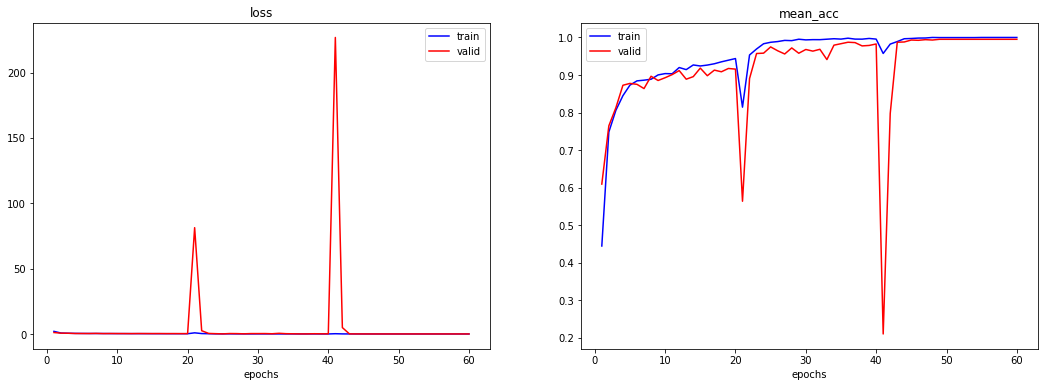

In [273]:
requires_grads = [x > 6 for x in range(len(net.features))]
print(f'requires_grads: {requires_grads}')

for ind, flag in enumerate(requires_grads):
  for param in net.features[ind].parameters():
    param.requires_grad = flag

loss_train, accuracy_train, loss_valid, accuracy_valid = train_model(net = net,
                                                         optimizer = optimizer,
                                                         criterion = criterion,
                                                         train_dataloader = train_dataloader,
                                                         val_dataloader = valid_dataloader,
                                                         num_epochs = 60)
f_print_results(loss_train, loss_valid, accuracy_train, accuracy_valid)

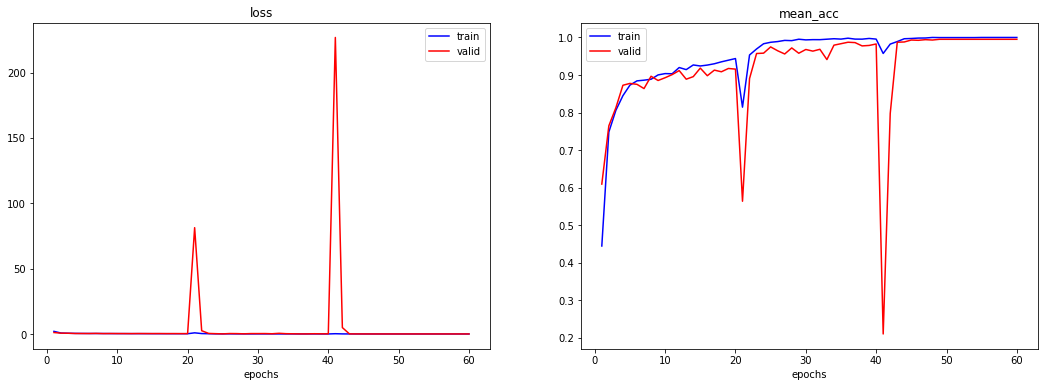

In [274]:
f_print_results(loss_train, loss_valid, accuracy_train, accuracy_valid)